## Exploring Rossmann Drug Store Sales Data

# Lesson 17

In [1]:
import pandas as pd
import seaborn as sb
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
data = pd.read_csv('../assets/dataset/rossmann.csv', skipinitialspace=True, low_memory=False)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# Filter to Store 1
store1_data = data[data.Store == 1]


In [3]:
# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

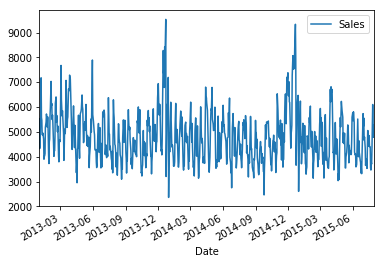

In [6]:
# Plot the sales over time
store1_open_data[['Sales']].plot()


In [7]:
print store1_data.Sales.autocorr(lag=1) # -0.12
print store1_data.Sales.autocorr(lag=2) # -0.03


-0.127325143391
-0.0347871557079


#### We do see some minimal correlation in time, implying an AR model can be useful.  An easier way to diagnose this may be to plot many autocorrelations at once.


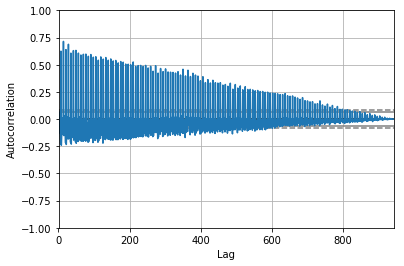

In [8]:
autocorrelation_plot(store1_data.Sales)


#### This shows a typical pattern of an autocorrelation plot, that it should decrease to 0 as lag increases.  However, it’s hard to observe exactly what the values are.


## Statsmodels
statsmodels provides a nice summary utility to help us diagnose models

statsmodels also has a better autocorrelation plot that allows us to look at fixed number of lag values.

Here we observe autocorrelation at 10 lag values.  1 and 2 are what we saw before.  

This implies a small but limited impact based on the last few values.  An autoregressive model might be useful.


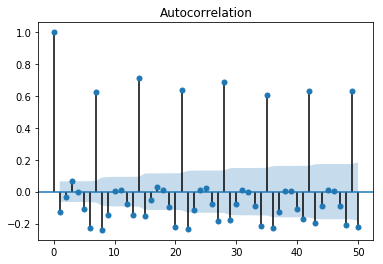

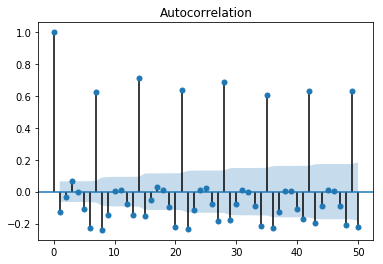

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(store1_data.Sales, lags=50)



#### We also see a larger spike at 7 (the seventh day in the week).  

#### If we observed a handful of random distributed spikes, a moving average model would be useful.  



#### We can expand the window to 25 days to see that the random spikes occur regularly at 7 days.  What does this mean?


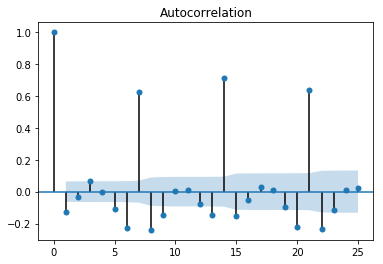

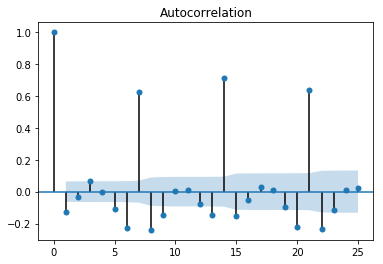

In [14]:
plot_acf(store1_data.Sales, lags=25)


#### AR
By passing (1, 0) in the second argument, we are fitting an ARMA model with p=1, q=0.  This is the same as an AR(1) model.

In this AR(1) model, we learn an intercept (or base sales) value.

Additionally, we learn a coefficient that tells us how to include the latest sales value.



In [15]:
from statsmodels.tsa.arima_model import ARMA

data = store1_open_data[['Sales']].astype(float)

model = ARMA(data, (1, 0)).fit()
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Wed, 05 Dec 2018   AIC                          12540.651
Time:                        14:05:40   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4761.9579     82.984     57.384      0.000    4599.312    4924.604
ar.L1.Sales     0.6822      0.026     26.122      0.000       0.631       0.733
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4659           +0.0000j            1.4659            0.0000
-----------------------------------------------------------------------------
"""

#### In this case, we add an intercept of ~4700 to 0.68 times the previous month’s sales.  Note that the coefficient is not equal to the lag 1 autocorrelation.  This implies the data is not stationary.


In [16]:
model = ARMA(data, (2, 0)).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Wed, 05 Dec 2018   AIC                          12542.063
Time:                        14:05:42   BIC                          12560.705
Sample:                    07-31-2015   HQIC                         12549.233
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.3980     85.262     55.856      0.000    4595.287    4929.509
ar.L1.Sales     0.6634      0.036     18.537      0.000       0.593       0.734
ar.L2.Sales     0.0275      0.036      0.767      0.443      -0.043       0.098
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4235           +0.0000j            1.4235            0.0000
AR.2          -25.5833           +0.0000j           25.5833            0.5000
-----------------------------------------------------------------------------
"""

#### Checking Fit
Here we see large spikes at the end of each year, indicating that our model does not account for the holiday spikes.  

Our model considers a short period of time, so it does not take into account the longer seasonal pattern.


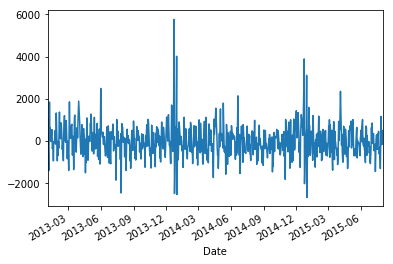

In [17]:
model.resid.plot()


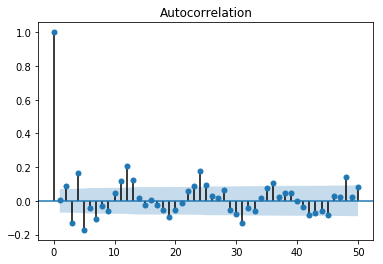

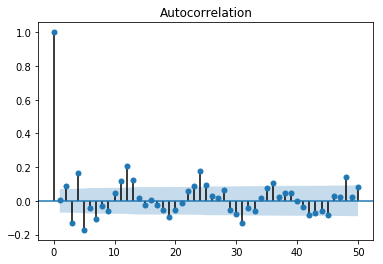

In [18]:
plot_acf(model.resid, lags=50)


#### This plot shows a problem:  the errors are increasing and decreasing every week in a clear pattern.

We may need to expand our model.


## ARMA
To expand this AR model to an ARMA model, we can include the moving average component as well.

Remember that this is an AR(1) + MA(1) model.  The AR coefficient represents dependency on the last value and the MA component represents any spikes independent of the last value.

The coefficients here are 0.69 for the AR component and -0.03 for the MA component.  


In [19]:
model = ARMA(data, (1, 1)).fit()



model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Wed, 05 Dec 2018   AIC                          12542.223
Time:                        14:05:49   BIC                          12560.865
Sample:                    07-31-2015   HQIC                         12549.392
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.1323     84.702     56.223      0.000    4596.120    4928.144
ar.L1.Sales     0.6979      0.035     20.095      0.000       0.630       0.766
ma.L1.Sales    -0.0294      0.045     -0.654      0.514      -0.118       0.059
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4328           +0.0000j            1.4328            0.0000
MA.1           34.0024           +0.0000j           34.0024            0.0000
-----------------------------------------------------------------------------
"""

Remember that this is an AR(1) + MA(1) model.  The AR coefficient represents dependency on the last value and the MA component represents any spikes independent of the last value.

The coefficients here are 0.69 for the AR component and -0.03 for the MA component.  

The AR coefficient is the same as before (decreasing values).

The MA component is fairly small (which we should have expected from the autocorrelation plots).


## ARIMA

In [21]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(data, (1, 1, 1)).fit()


model.summary()
    



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6261.011
Method:                       css-mle   S.D. of innovations            738.624
Date:                Wed, 05 Dec 2018   AIC                          12530.022
Time:                        14:07:00   BIC                          12548.659
Sample:                    07-30-2015   HQIC                         12537.190
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5108      0.364      1.405      0.160      -0.202       1.223
ar.L1.D.Sales     0.6801      0.026     25.801      0.000       0.628       0.732
ma.L1.D.Sales    -1.0000      0.004   -240.409      0.000      -1.008      -0.992
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4703           +0.0000j            1.4703            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

We can remove the MA component since it does not appear to be useful.


In [22]:
model = ARIMA(data, (1, 1, 0)).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6313.616
Method:                       css-mle   S.D. of innovations            792.680
Date:                Wed, 05 Dec 2018   AIC                          12633.233
Time:                        14:07:03   BIC                          12647.211
Sample:                    07-30-2015   HQIC                         12638.609
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2161     24.028      0.009      0.993     -46.877      47.309
ar.L1.D.Sales    -0.1815      0.035     -5.150      0.000      -0.251      -0.112
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.5103           +0.0000j            5.5103            0.5000
-----------------------------------------------------------------------------
"""


We now have an AR(1) model on the differenced series with a coefficient of -0.18.


#### We can compute the lag 1 autocorrelation of the differenced series and see if they match.


In [23]:
data.Sales.diff(1).autocorr(1) #-0.181


-0.18144101447610664

#### We can also plot it to see the difference.


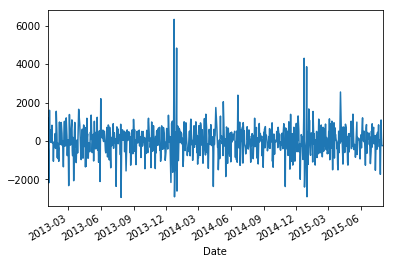

In [24]:
data.Sales.diff(1).plot()


They match.  Note that this is generally true, but the variance is NOT constant.  It’s mostly the same throughout the series except around the holidays.


## Predictions

With our models, we can also plot our predictions against the true series using the plot_predict function.


##### The function takes two arguments, the start and end index of the dataframe to plot.  Here, we are plotting the last 50 values.


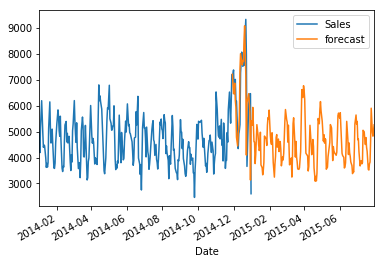

In [25]:
fig, ax = plt.subplots()
ax = data['2014'].plot(ax=ax)
fig = model.plot_predict( 1, 200, ax=ax, plot_insample=False)


To plot earlier values with our predictions continuing where the true values stop, we can do the following.

This plots true values in 2014 and our predictions 200 days out from 2014.



### Fixing the holiday issue


The two previous problems remain:

Large errors around the holiday period

Errors with high autocorrelation


In [26]:
model = ARIMA(data, (7, 1, 2)).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -6221.636
Method:                       css-mle   S.D. of innovations            703.783
Date:                Wed, 05 Dec 2018   AIC                          12465.272
Time:                        14:07:54   BIC                          12516.524
Sample:                    07-30-2015   HQIC                         12484.984
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6870      4.555      0.151      0.880      -8.240       9.614
ar.L1.D.Sales     0.8404      0.211      3.982      0.000       0.427       1.254
ar.L2.D.Sales    -0.1503      0.145     -1.038      0.300      -0.434       0.134
ar.L3.D.Sales    -0.1831      0.046     -3.976      0.000      -0.273      -0.093
ar.L4.D.Sales     0.2557      0.060      4.296      0.000       0.139       0.372
ar.L5.D.Sales    -0.3381      0.067     -5.018      0.000      -0.470      -0.206
ar.L6.D.Sales     0.0691      0.074      0.931      0.352      -0.076       0.215
ar.L7.D.Sales    -0.0656      0.050     -1.325      0.185      -0.163       0.031
ma.L1.D.Sales    -1.1350      0.209     -5.443      0.000      -1.544      -0.726
ma.L2.D.Sales     0.2373      0.197      1.203      0.229      -0.149       0.624
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2128           -0.0000j            1.2128           -0.5000
AR.2            1.0141           -0.4950j            1.1285           -0.0723
AR.3            1.0141           +0.4950j            1.1285            0.0723
AR.4           -0.1357           -1.7545j            1.7597           -0.2623
AR.5           -0.1357           +1.7545j            1.7597            0.2623
AR.6            0.2547           -1.7666j            1.7848           -0.2272
AR.7            0.2547           +1.7666j            1.7848            0.2272
MA.1            1.1647           +0.0000j            1.1647            0.0000
MA.2            3.6180           +0.0000j            3.6180            0.0000
-----------------------------------------------------------------------------
"""

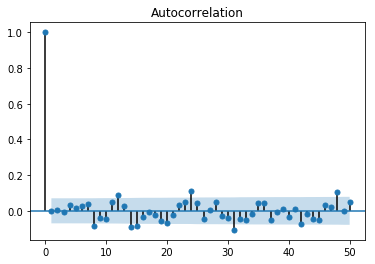

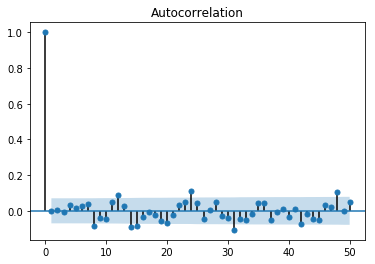

In [27]:
plot_acf(model.resid, lags=50)
